# Kaggle - Space Titanic - Spark framework

This notebooks is used as practice for ML applied to Kaggle Space Titanic training problem and pySpark practice
https://www.kaggle.com/competitions/spaceship-titanic/data?select=train.csv

In [21]:
# import libraries
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation, ChiSquareTest
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer, MinMaxScaler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from xgboost.spark import SparkXGBClassifier, SparkXGBRegressor

import pandas as pd
import numpy as np
import seaborn as sns

## Import data to local Spark Framework

Load data from CSV and organize schema

In [22]:
# set env viroment for localhost if needed

# spark = SparkSession.builder.config("spark.driver.host", "localhost").getOrCreate()
# spark = SparkSession.builder.master("local[*]").getOrCreate()
spark =SparkSession.builder.master("spark://localhost:4041/").getOrCreate()

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled","true")

train_spark = spark.read.format('csv').option("header",True).load('./train.csv')
test_spark = spark.read.format('csv').option("header",True).load('./test.csv')

In [23]:
spark

In [24]:
train_spark.show()
train_spark.printSchema()

+-----------+----------+---------+-----+-------------+----+-----+-----------+---------+------------+------+------+------------------+-----------+
|PassengerId|HomePlanet|CryoSleep|Cabin|  Destination| Age|  VIP|RoomService|FoodCourt|ShoppingMall|   Spa|VRDeck|              Name|Transported|
+-----------+----------+---------+-----+-------------+----+-----+-----------+---------+------------+------+------+------------------+-----------+
|    0001_01|    Europa|    False|B/0/P|  TRAPPIST-1e|39.0|False|        0.0|      0.0|         0.0|   0.0|   0.0|   Maham Ofracculy|      False|
|    0002_01|     Earth|    False|F/0/S|  TRAPPIST-1e|24.0|False|      109.0|      9.0|        25.0| 549.0|  44.0|      Juanna Vines|       True|
|    0003_01|    Europa|    False|A/0/S|  TRAPPIST-1e|58.0| True|       43.0|   3576.0|         0.0|6715.0|  49.0|     Altark Susent|      False|
|    0003_02|    Europa|    False|A/0/S|  TRAPPIST-1e|33.0|False|        0.0|   1283.0|       371.0|3329.0| 193.0|      Sola

## Data wrangling

In [25]:
def spark_df_format(input_spark_df):
       spark_df = input_spark_df

       # cast types/schema
       if 'Transported' in spark_df.columns:
              spark_df = spark_df.withColumn("Transported",col("Transported").cast("boolean")).withColumn("Transported",col("Transported").cast("double"))
       else:
              spark_df.withColumn('Transported', 0)
       spark_df = spark_df.withColumn("CryoSleep",col("CryoSleep").cast("boolean")).withColumn("CryoSleep",col("CryoSleep").cast("integer"))
       spark_df = spark_df.withColumn("VIP",col("VIP").cast("boolean")).withColumn("VIP",col("VIP").cast("integer"))
       spark_df = spark_df.withColumn("Age",col("Age").cast("double"))
       spark_df = spark_df.withColumn("RoomService",col("RoomService").cast("double"))
       spark_df = spark_df.withColumn("FoodCourt",col("FoodCourt").cast("double"))
       spark_df = spark_df.withColumn("ShoppingMall",col("ShoppingMall").cast("double"))
       spark_df = spark_df.withColumn("Spa",col("Spa").cast("double"))
       spark_df = spark_df.withColumn("VRDeck",col("VRDeck").cast("double"))

       # breakdown cabin address
       spark_df =  spark_df.withColumn('deck', split(spark_df['Cabin'], '/').getItem(0)) \
              .withColumn('num', split(spark_df['Cabin'], '/').getItem(1)) \
              .withColumn('side', split(spark_df['Cabin'], '/').getItem(2))
       spark_df = spark_df.withColumn("num",col("num").cast("double"))

       return spark_df

def spark_pipeline_transform(input_spark_df, pipeline = None):
       spark_df = input_spark_df

       # drop na for transported
       spark_df.dropna(subset='Transported')

       # fill na for booleans
       spark_df = spark_df.fillna(subset=['CryoSleep','VIP'],value=-1)

       # fill na for floats
       spark_df = spark_df.fillna(subset=['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','num'], value=0)

       if pipeline is None:
              cate_list = ['HomePlanet','Destination','deck','side']
              bool_list = ['Transported','CryoSleep','VIP']
              float_list = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','num']
              
              stages_list = []

              # convert strings to indexes
              stages_list = stages_list + [
                     StringIndexer(inputCol=c, outputCol=c+'_idx', handleInvalid='keep')
                     for c in cate_list
              ]

              # vectorize columns
              stages_list = stages_list + [
                     VectorAssembler(inputCols=[c+'_idx'], outputCol=c+'_vec', handleInvalid='keep')
                     for c in cate_list
              ]
              stages_list = stages_list + [
                     VectorAssembler(inputCols=[c], outputCol=c+'_vec', handleInvalid='keep')
                     for c in float_list+bool_list
              ]

              # minmax scale floats
              stages_list = stages_list + [
                     MinMaxScaler(inputCol=c+"_vec", outputCol=c+"_scaled") for c in float_list
              ]

              # one hot encode
              stages_list = stages_list + [OneHotEncoder(inputCols=[c+"_idx" for c in cate_list],
                     outputCols=[c+"_ohe" for c in cate_list], handleInvalid='keep'
              )]

              pipeline = Pipeline(stages=stages_list)

       spark_df = pipeline.fit(spark_df).transform(spark_df)

       # build continuous and categorical part (data analytics)
       cont_spark_df = spark_df.select(['Transported']+[c for c in float_list])
       cate_spark_df = spark_df.select(['Transported_vec']+[c+'_vec' for c in cate_list+bool_list])
       
       return spark_df, cont_spark_df, cate_spark_df, pipeline

In [26]:
full_df = spark_df_format(train_spark)
full_df, cont_spark_df, cate_spark_df, pipeline = spark_pipeline_transform(full_df)
cont_spark_df.show()
cont_spark_df.head(5)

+-----------+----+-----------+---------+------------+------+------+---+
|Transported| Age|RoomService|FoodCourt|ShoppingMall|   Spa|VRDeck|num|
+-----------+----+-----------+---------+------------+------+------+---+
|        0.0|39.0|        0.0|      0.0|         0.0|   0.0|   0.0|0.0|
|        1.0|24.0|      109.0|      9.0|        25.0| 549.0|  44.0|0.0|
|        0.0|58.0|       43.0|   3576.0|         0.0|6715.0|  49.0|0.0|
|        0.0|33.0|        0.0|   1283.0|       371.0|3329.0| 193.0|0.0|
|        1.0|16.0|      303.0|     70.0|       151.0| 565.0|   2.0|1.0|
|        1.0|44.0|        0.0|    483.0|         0.0| 291.0|   0.0|0.0|
|        1.0|26.0|       42.0|   1539.0|         3.0|   0.0|   0.0|2.0|
|        1.0|28.0|        0.0|      0.0|         0.0|   0.0|   0.0|0.0|
|        1.0|35.0|        0.0|    785.0|        17.0| 216.0|   0.0|3.0|
|        1.0|14.0|        0.0|      0.0|         0.0|   0.0|   0.0|1.0|
|        1.0|34.0|        0.0|      0.0|         0.0|   0.0|   0

[Row(Transported=0.0, Age=39.0, RoomService=0.0, FoodCourt=0.0, ShoppingMall=0.0, Spa=0.0, VRDeck=0.0, num=0.0),
 Row(Transported=1.0, Age=24.0, RoomService=109.0, FoodCourt=9.0, ShoppingMall=25.0, Spa=549.0, VRDeck=44.0, num=0.0),
 Row(Transported=0.0, Age=58.0, RoomService=43.0, FoodCourt=3576.0, ShoppingMall=0.0, Spa=6715.0, VRDeck=49.0, num=0.0),
 Row(Transported=0.0, Age=33.0, RoomService=0.0, FoodCourt=1283.0, ShoppingMall=371.0, Spa=3329.0, VRDeck=193.0, num=0.0),
 Row(Transported=1.0, Age=16.0, RoomService=303.0, FoodCourt=70.0, ShoppingMall=151.0, Spa=565.0, VRDeck=2.0, num=1.0)]

### Correlation check

In [27]:
# define function to create and plot correlation matrix with Spark dataframe
def spark_corr(spark_df, plot=False):
    cor_df = VectorAssembler(inputCols=spark_df.columns, outputCol='features',handleInvalid='skip').transform(spark_df)
    cor_df = Correlation.corr(cor_df,column='features')
    
    corr_matrix = cor_df.collect()[0][0].toArray().tolist() 
    corr_matrix = pd.DataFrame(data=corr_matrix, columns=spark_df.columns, index=spark_df.columns)

    if plot:
        sns.heatmap(corr_matrix, annot=True)
        pass

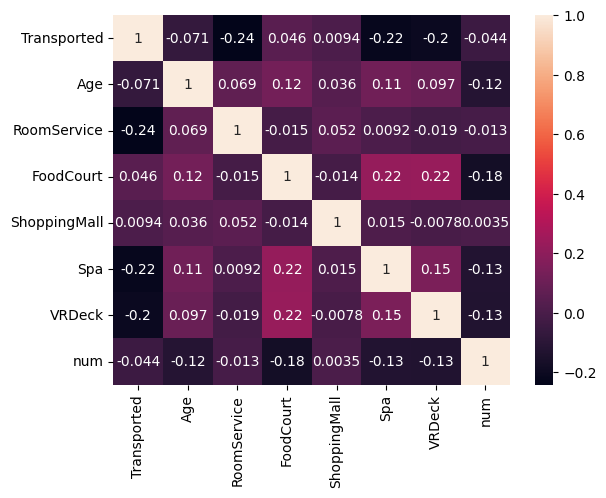

In [28]:
spark_corr(cont_spark_df, True)

### P-Value check

In [29]:
def spark_chi_sq(spark_df, targetName = 'target', featureName = 'feature'):
    # spark_df.crosstab(targetName,featureName).show()
    chi_df = ChiSquareTest.test(spark_df, featureName, targetName)

    return chi_df

In [30]:
aux = spark_chi_sq(full_df, 'Transported', 'VIP_vec')
aux.show(truncate=False)

+-----------------------+----------------+--------------------+
|pValues                |degreesOfFreedom|statistics          |
+-----------------------+----------------+--------------------+
|[0.0023608448102931945]|[2]             |[12.097471507075117]|
+-----------------------+----------------+--------------------+



In [31]:
for c in ['VIP_vec','CryoSleep_vec','HomePlanet_vec','Destination_vec','deck_vec','side_vec']:
    pVal = spark_chi_sq(full_df, 'Transported', c).select(['pValues']).collect()[0][0].toArray().tolist()[0]
    print(f'{c} p-value: {pVal}')

VIP_vec p-value: 0.0023608448102931945
CryoSleep_vec p-value: 0.0
HomePlanet_vec p-value: 0.0
Destination_vec p-value: 0.0
deck_vec p-value: 0.0
side_vec p-value: 0.0


# Machine Learning Models

In this notebook it will be tested a simple decision tree model and XBoost model for comparrison

## ML models

In this notebook, it will be tested a decision tree and XGBoost models for comparrison

In [32]:
# Divide into training and validation dataset
target_list = ['Transported']
features_list = ['HomePlanet_ohe','Destination_ohe','deck_ohe','side_ohe','CryoSleep_vec','VIP_vec',
    'Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','num']

ml_df = full_df.select(target_list + features_list)
ml_df = VectorAssembler(inputCols=features_list, outputCol='features',handleInvalid='keep').transform(ml_df)

train_df, test_df = ml_df.randomSplit(weights=[0.8,0.2], seed=200)

### Decision Tree

In [33]:
decisionTree = DecisionTreeClassifier(labelCol="Transported", featuresCol="features")
model = decisionTree.fit(train_df)

In [34]:
pred_df = model.transform(test_df)

# evaluator = MulticlassClassificationEvaluator(labelCol="Transported", predictionCol="prediction", metricName="accuracy")
# accuracy = evaluator.evaluate(pred_df)

# print('Accuracy: {0:.2f} %'.format(accuracy*100))

In [35]:
preds = pred_df.select(['prediction','Transported']).withColumn('transport', col("Transported").cast("double"))
preds = preds.select(['prediction','transport']).withColumn('predict', col("prediction").cast("double"))
preds = preds.select(['predict','transport'])

In [36]:
metrics = MulticlassClassificationEvaluator(labelCol='transport',predictionCol='predict')
metrics.evaluate(preds)

confusionMatrix = preds.crosstab('transport', 'predict')
confusionMatrix.show()

+-----------------+---+---+
|transport_predict|0.0|1.0|
+-----------------+---+---+
|              1.0|120|779|
|              0.0|593|268|
+-----------------+---+---+



In [37]:
train_df.show()

+-----------+--------------+---------------+-------------+-------------+-------------+-------+----+-----------+---------+------------+------+------+------+--------------------+
|Transported|HomePlanet_ohe|Destination_ohe|     deck_ohe|     side_ohe|CryoSleep_vec|VIP_vec| Age|RoomService|FoodCourt|ShoppingMall|   Spa|VRDeck|   num|            features|
+-----------+--------------+---------------+-------------+-------------+-------------+-------+----+-----------+---------+------------+------+------+------+--------------------+
|        0.0| (4,[0],[1.0])|  (4,[0],[1.0])|(9,[0],[1.0])|(3,[0],[1.0])|       [-1.0]|  [0.0]|15.0|       10.0|      0.0|        99.0|   0.0|2031.0| 627.0|(29,[0,4,8,17,20,...|
|        0.0| (4,[0],[1.0])|  (4,[0],[1.0])|(9,[0],[1.0])|(3,[0],[1.0])|       [-1.0]|  [0.0]|21.0|        0.0|     20.0|      1540.0|  80.0| 512.0|1248.0|(29,[0,4,8,17,20,...|
|        0.0| (4,[0],[1.0])|  (4,[0],[1.0])|(9,[0],[1.0])|(3,[0],[1.0])|       [-1.0]|  [0.0]|51.0|      437.0|    

### XGBoost

In [38]:
target_list = ['Transported','Transported_vec']
# features_list = ['HomePlanet_vec','Destination_vec','deck_vec','side_vec','CryoSleep_vec','VIP_vec',
#     'Age_scaled','RoomService_scaled','FoodCourt_scaled','ShoppingMall_scaled','Spa_scaled','VRDeck_scaled','num_scaled']
features_list = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','num']

ml_df = full_df.select(target_list + features_list)

ml_df = ml_df.fillna(value=-1)

ml_df = VectorAssembler(inputCols=features_list, outputCol='featuresRaw',handleInvalid='keep').transform(ml_df)
ml_df = VectorIndexer(inputCol="featuresRaw", outputCol="features").fit(ml_df).transform(ml_df)

# ml_df = ml_df.select(target_list + features_list)

train_df, test_df = ml_df.randomSplit(weights=[0.8,0.2], seed=200)

train_df

DataFrame[Transported: double, Transported_vec: vector, Age: double, RoomService: double, FoodCourt: double, ShoppingMall: double, Spa: double, VRDeck: double, num: double, featuresRaw: vector, features: vector]

In [39]:
spark_class_estimator = SparkXGBClassifier(
    label_col="Transported",
    features_col=features_list,
    missing=0.0,
    device='gpu'
)

spark_class_estimator = spark_class_estimator.fit(train_df)

2023-12-08 18:56:15,868 WARNING SparkXGBClassifier: _validate_gpu_params You have enabled GPU in spark local mode. Please make sure your local node has at least 1 GPUs
2023-12-08 18:56:16,458 INFO XGBoost-PySpark: _fit Running xgboost-2.0.2 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'gpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
2023-12-08 18:56:16,709 INFO SparkXGBClassifier: _skip_stage_level_scheduling Stage-level scheduling in xgboost requires spark standalone or local-cluster mode


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Could not recover from a failed barrier ResultStage. Most recent failure reason: Stage failed because barrier task ResultTask(251, 0) finished unsuccessfully.
org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.sql.execution.python.MapInBatchEvaluatorFactory$MapInBatchEvaluator.eval(MapInBatchEvaluatorFactory.scala:74)
	at org.apache.spark.sql.execution.python.MapInBatchExec.$anonfun$doExecute$2(MapInBatchExec.scala:78)
	at org.apache.spark.sql.execution.python.MapInBatchExec.$anonfun$doExecute$2$adapted(MapInBatchExec.scala:77)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:877)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:877)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.sql.execution.SQLExecutionRDD.$anonfun$compute$1(SQLExecutionRDD.scala:52)
	at org.apache.spark.sql.internal.SQLConf$.withExistingConf(SQLConf.scala:158)
	at org.apache.spark.sql.execution.SQLExecutionRDD.compute(SQLExecutionRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:708)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:752)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 36 more

	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskCompletion(DAGScheduler.scala:2216)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3042)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1046)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1045)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:195)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
